# Testing StaticManager

In [1]:
from ubs8k.datasetManager import StaticManager
from ubs8k.datasetManager import DatasetManager

from ubs8k.generators import CoTrainingDataset

import ubs8k.signal_augmentations as sa

In [2]:
metadata_root = "../dataset/metadata"
audio_root = "../dataset/audio"
static_aug_file = "../dataset/audio/urbansound8k_22050_augmentations.hdf5"

classic_manager = DatasetManager(metadata_root, audio_root, train_fold=[1], val_fold=[], verbose=1)
static_manager = StaticManager(metadata_root, audio_root, train_fold=[1], val_fold=[], static_augment_file=static_aug_file)

100%|██████████| 1/1 [00:01<00:00,  1.49s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.49s/it]
0it [00:00, ?it/s]


In [3]:
import h5py
with h5py.File(static_aug_file, "r") as hdf:
    for key in hdf["fold1"].keys():
        print("key: %s \t nb flavor: %s" % (key, hdf["fold1"][key].shape))

key: N2 	 nb flavor: (4, 873, 88200)
key: PSC1 	 nb flavor: (3, 873, 88200)
key: PSC2 	 nb flavor: (3, 873, 88200)
key: filenames 	 nb flavor: (873,)


In [51]:
# static_manager.add_augmentation("PSC1")
static_manager.add_augmentation("N2")

100%|██████████| 1/1 [00:07<00:00,  7.15s/it]

(4, 873, 88200)
873 4


# Test the features extracted by the classic and static dataset

## Test one fold, check mean and std

In [52]:
from IPython import display
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
from ipywidgets import interact, interactive, fixed, interact_manual
import numpy as np
plt.style.use('dark_background')

In [53]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
            

In [54]:
from tqdm import trange
                                              
original_mean, original_std = [], []
static_mean, static_std = [], []
dynamic_mean, dynamic_std = [], []
augmentation="N2"
static_augments = {augmentation: 1.0} # apply static PSC 1 all the time (flavor will be random)

In [55]:
classic_dataset = CoTrainingDataset(
    classic_manager, 1.0, # <-- all file are supervised. easier to gather all the files 1 by 1
    train=True, val=False,
    augments=[],
    S_augment=False, U_augment=False,
    cached=False
)

dynamic_dataset = CoTrainingDataset(
    classic_manager, 1.0,
    train=True, val=False,
    augments=[sa.Noise(1.0, target_snr=20)], # N2
    #augments=[sa.PitchShiftChoice(1.0, choice=(-1.5, -1.0, 1.0, 1.5))], # PSC 2
#     augments=[sa.PitchShiftChoice(1.0, choice=(-3, -2, 2, 3))], # PSC 1
    S_augment=True, U_augment=False,
    cached=False
)

static_dataset = CoTrainingDataset(
    static_manager, 1.0, # <-- all file are supervised. easier to gather all the files 1 by 1
    train=True, val=False,
    augments=[], static_augmentation=static_augments,
    S_augment=True, U_augment=False,
    cached=False
)

In [56]:
nb_classic_files = len(classic_dataset)
nb_static_files = len(static_dataset)

for i in trange(nb_classic_files):
    # create special indexing form for CoTrainingDataset (see samplers.py)
    index = [[i], [], []]  # [S1, S2, U]
    ((classic_s1, _, _), _) = classic_dataset[index] # return under the form ((s1, s2, u), y)
    ((dynamic_s1, _, _), _) = dynamic_dataset[index]
    ((static_s1, _, _), _) = static_dataset[index]
    
    original_mean.append(np.mean(classic_s1))
    original_std.append(np.std(classic_s1))

    dynamic_mean.append(np.mean(dynamic_s1))
    dynamic_std.append(np.std(dynamic_s1))
    
    static_mean.append(np.mean(static_s1))
    static_std.append(np.std(static_s1))

100%|██████████| 873/873 [00:17<00:00, 48.81it/s]


In [57]:
original_mean = np.asarray(original_mean)
original_std = np.asarray(original_std)

static_mean = np.asarray(static_mean)
static_std = np.asarray(static_std)

dynamic_mean = np.asarray(dynamic_mean)
dynamic_std = np.asarray(dynamic_std)

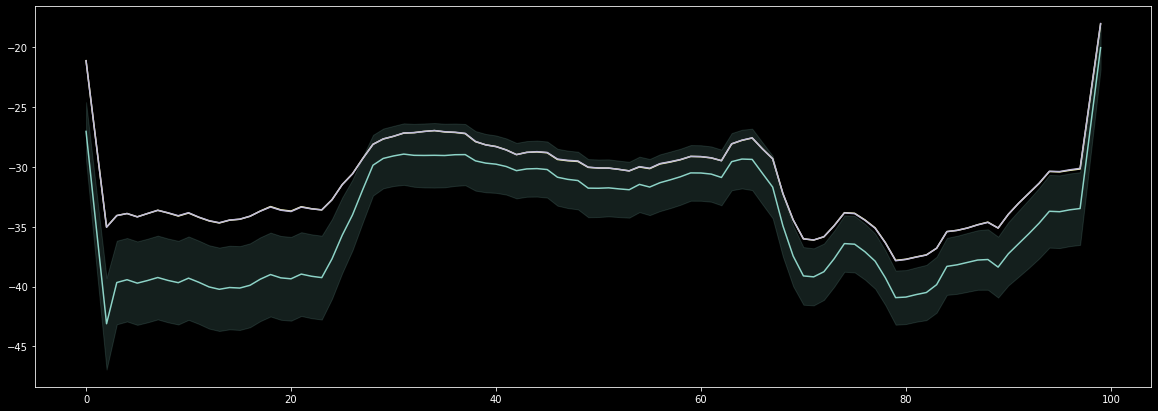

In [58]:
start=0
end=100
x = list(range(end-start))

display_ratio = 0.2
smooth_window = 5
om = smooth(original_mean[start:end], smooth_window)
ost = smooth(original_std[start:end] * display_ratio, smooth_window)

sm = smooth(static_mean[start:end], smooth_window)
sst = smooth(static_std[start:end] * display_ratio, smooth_window)

dm = smooth(dynamic_mean[start:end], smooth_window)
dst = smooth(dynamic_std[start:end] * display_ratio, smooth_window)

plt.figure(0, figsize=(20, 7))
plt.plot(x, om, color="C0")
plt.fill_between(x, om-ost, om+ost, color="C0", alpha=0.15)

plt.plot(x, sm, color="C1")
# plt.fill_between(x, sm-sst, sm+sst, color="C1", alpha=0.15)

plt.plot(x, dm, color="C2")
# plt.fill_between(x, dm-dst, dm+dst, color="C2", alpha=0.15)

plt.show()

## Check one file

In [59]:
index = 400
((classic_x, _, _), _) = classic_dataset[[[index], [], []]]
((static_x, _, _), _) = static_dataset[[[index], [], []]]
((dynamic_x, _, _), _) = dynamic_dataset[[[index], [], []]]

In [60]:
print(classic_x.dtype)
print(static_x.dtype)
print(dynamic_x.dtype)

float32
float32
float32


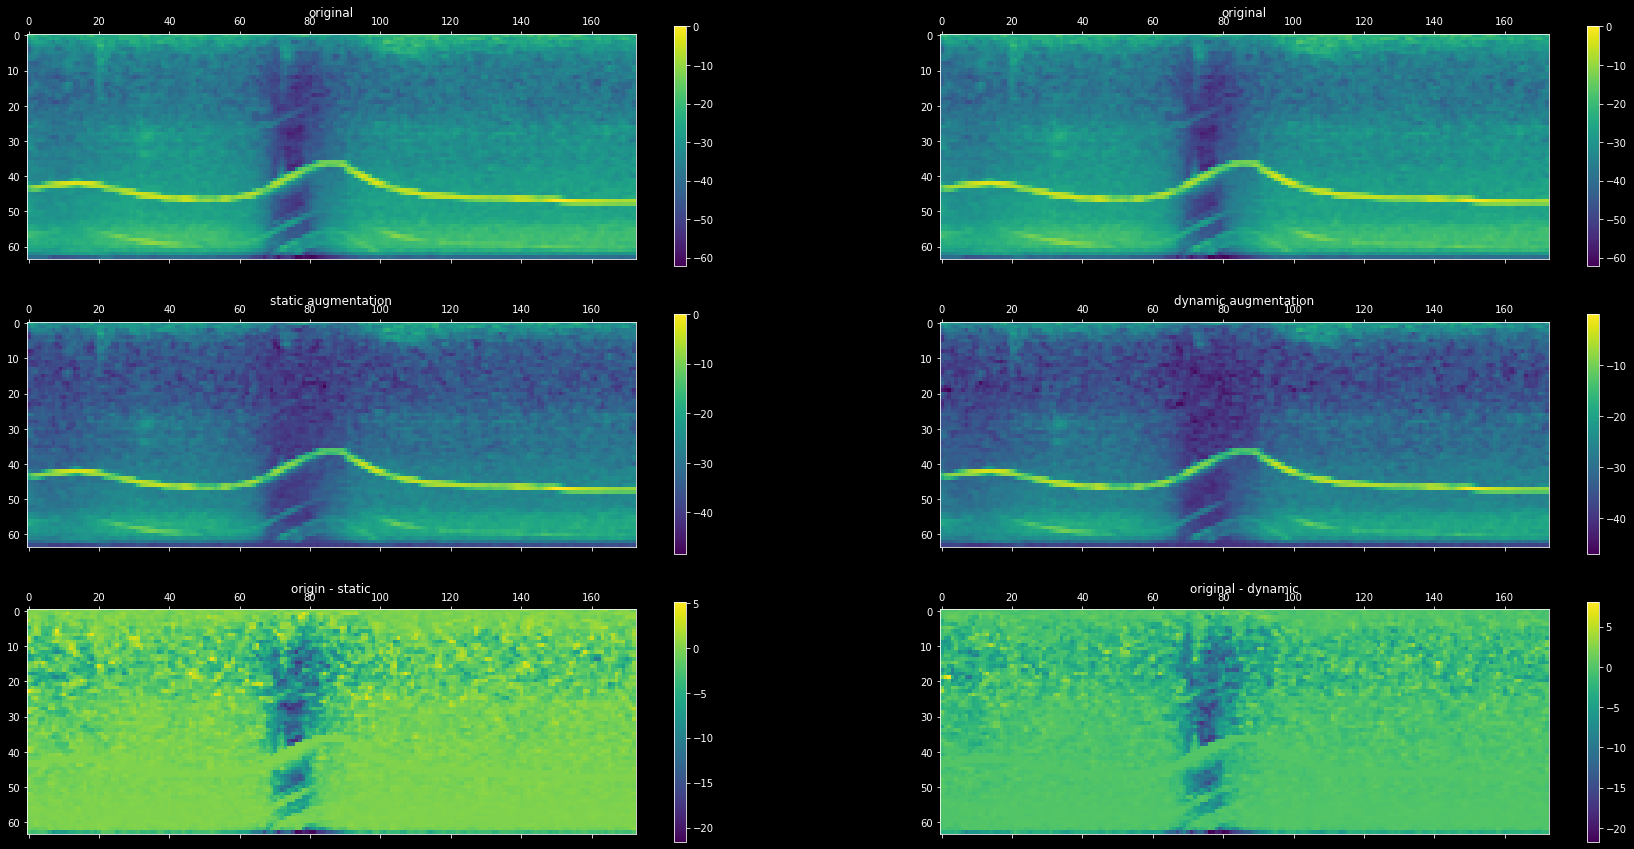

In [61]:
plt.figure(0, figsize=(30, 15))
plt.subplot(3, 2, 1)
plt.title("original")
plt.matshow(classic_x.squeeze(), fignum=0)
plt.colorbar()

plt.subplot(3, 2, 3)
plt.title("static augmentation")
plt.matshow(static_x.squeeze(), fignum=0)
plt.colorbar()

plt.subplot(3, 2, 5)
plt.title("origin - static")
plt.matshow(classic_x.squeeze() - static_x.squeeze(), fignum=0)
plt.colorbar()

# -------------
plt.subplot(3, 2, 2)
plt.title("original")
plt.matshow(classic_x.squeeze(), fignum=0)
plt.colorbar()

plt.subplot(3, 2, 4)
plt.title("dynamic augmentation")
plt.matshow(dynamic_x.squeeze(), fignum=0)
plt.colorbar()

plt.subplot(3, 2, 6)
plt.title("original - dynamic")
plt.matshow(classic_x.squeeze() - dynamic_x.squeeze(), fignum=0)
plt.colorbar()

plt.show()

# Check difference with file extracted from the manager

In [78]:
filenames = list(classic_manager.audio["train"].keys())

classic_raw = np.asarray([classic_manager.audio["train"][key] for key in filenames])
static_raw = np.asarray([static_manager.static_augmentation["train"][augmentation][key][0] for key in filenames])

In [79]:
classic_raw.shape, static_raw.shape, classic_raw[0].dtype, static_raw[0].dtype

((873, 88200), (873, 88200), dtype('<f8'), dtype('<f4'))

In [80]:
classic_raw_mean = np.mean(classic_raw, axis=1)
classic_raw_std = np.std(classic_raw, axis=1)

static_raw_mean = np.mean(static_raw, axis=1)
static_raw_std = np.std(static_raw, axis=1)

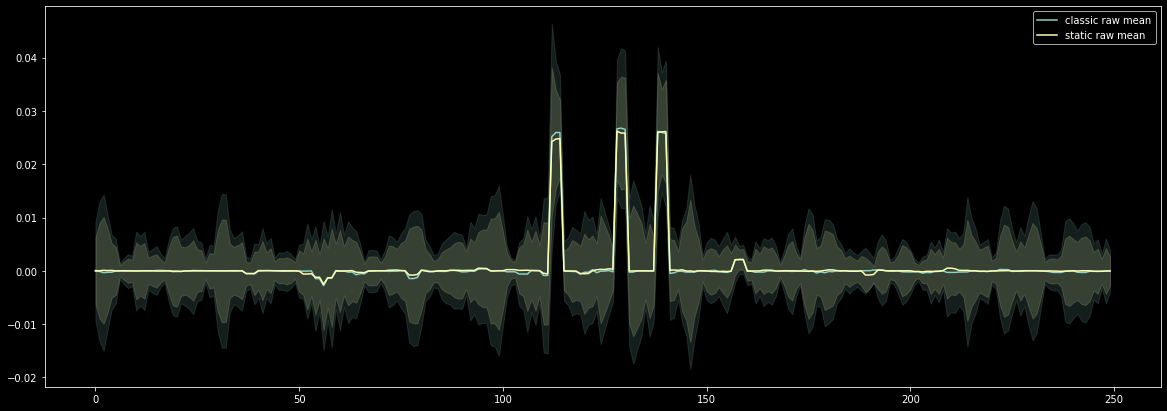

In [81]:
start=0
end=250
x = list(range(end-start))

display_ratio = 0.1
smooth_window = 3
om = smooth(classic_raw_mean[start:end], smooth_window)
ost = smooth(classic_raw_std[start:end] * display_ratio, smooth_window)
am1 = smooth(static_raw_mean[start:end], smooth_window)
ast1 = smooth(static_raw_std[start:end] * display_ratio, smooth_window)

plt.figure(0, figsize=(20, 7))
plt.plot(x, om, color="C0", label= "classic raw mean")
plt.fill_between(x, om-ost, om+ost, color="C0", alpha=0.15)

plt.plot(x, am1, color="C1", label="static raw mean")
plt.fill_between(x, am1-ast1, am1+ast1, color="C1", alpha=0.15)

plt.legend()
plt.show()

In [ ]:
python co-training_static_aug.py --model cnn -t 1 2 3 4 5 6 7 8 9 -v 10 --base_lr 0.01 --lambda_cot_max 5 --lambda_diff_max 0.25 --warm_up 160 --epsilon 0.1  --subsampling 0.1 --subsampling_method balance -T test  --log info --augment_S --static_augments="{'N2': 0.75}"